In [13]:
import os
import pandas as pd
import numpy as np
from collections import OrderedDict

# Load the data

In [11]:
rdoc_lists = pd.read_csv("../lists/lists/lists_rdoc_domain_opsim.csv", index_col=None)
rdoc_doms = list(OrderedDict.fromkeys(rdoc_lists["DOMAIN"]))
rdoc_names = ["Negative Valence", "Positive Valence", "Cognitive Systems",
              "Social Processes", "Arousal & Regulation", "Sensorimotor Systems"]

In [12]:
meta = pd.read_csv("../data/metadata_filt_180811.csv", index_col=None)
meta = meta.dropna(subset=["PMID"])
meta["PMID"] = meta["PMID"].astype(int)
meta.head(1)

,PMID,DOI,KEY,SOURCE,AUTHORS,YEAR,MONTH,JOURNAL,TITLE,PAGES,VOLUME,ABSTRACT_URL,NUM_COORDINATES,MNI_COORDINATES,BRAINMAP_ID,BEHAVIORAL_DOMAIN,EXPERIMENT,DESCRIPTION
0,1402966,NaN,"Dolan R J, 1992",BrainMap,Dolan R J|Bench C J|Brown R G|Scott L C|Fristo...,1992.0,Sep,"Journal of Neurology, Neurosurgery, and Psychi...",Regional cerebral blood flow abnormalities in ...,768-773,55,http://www.ncbi.nlm.nih.gov/entrez/query.fcgi?...,7.0,"-7.66,51.87,-8.33;-5.51,56.46,-4.28;-5.48,58.9...",6030020.0,"['Action.Rest', 'Action.Rest']","['Unimpaired > Impaired', 'Impaired > Unimpair...",Patients with depression who were cognitively ...


In [46]:
cit = {}
files = [file for file in os.listdir("data/dimensions") if file.startswith("data_")]
for file in files:
    df = pd.read_csv("data/dimensions/{}".format(file), skiprows=1, header=0)
    df = df.fillna(0)
    df["PMID"] = df["PMID"].astype(int)
    df = df[df["PMID"].isin(meta["PMID"])]
    for i, row in df.iterrows():
        cit[row["PMID"]] = row["Times cited"]
print(len(cit.keys()))

18155


# Segment by occurrence of "RDoC"

In [117]:
dir = "../../../nlp/corpus"
pmids_rdoc = np.zeros(len(meta["PMID"]))
for i, pmid in enumerate(meta["PMID"]):
    infile = "{}/{}.txt".format(dir, pmid)
    text = open(infile, "r").read().split()
    if "rdoc" in text:
        pmids_rdoc[i] = 1.0

In [118]:
sum(pmids_rdoc)

112.0

## Average citations within group

In [49]:
cit_raw = np.zeros(len(meta["PMID"]))
for i, pmid in enumerate(meta["PMID"]):
    cit_raw[i] = cit[pmid]

In [61]:
parts = ["RDoC Did NOT Occur", "RDoC Occurred"]
for i, part in enumerate(parts):
    print("{:20s} {:6.4f} mean citations".format(part, 
          np.mean(cit_raw[pmids_rdoc == i])))

RDoC Did NOT Occur   65.3549 mean citations
RDoC Occurred        16.6875 mean citations


## Normalize by publication year

In [116]:
yr = 2019.0 - meta["YEAR"].astype(float).values
cit_norm = cit_raw / yr

In [62]:
for i, part in enumerate(parts):
    print("{:20s} {:6.4f} mean citations".format(part, 
          np.mean(cit_norm[pmids_rdoc == i])))

RDoC Did NOT Occur   6.2837 mean citations
RDoC Occurred        4.3292 mean citations


# Segment by RDoC domain 

In [119]:
doc2dom = pd.read_csv("../data/doc2dom_rdoc_domain.csv", header=None, index_col=0)
doc2dom = doc2dom.loc[meta["PMID"]].values
doc2dom = doc2dom - 1

### Observed

In [122]:
cit_norm_dom = np.empty((len(rdoc_names)))
for i, dom in enumerate(rdoc_doms):
    dom_mean = np.mean(cit_norm.reshape(-1,1)[doc2dom == i])
    cit_norm_dom[i] = dom_mean
    print("{:20s} {:6.4f}".format(dom, dom_mean))
print("\n{:20s} {:6.4f}".format("MEAN", np.mean(cit_norm)))

NEGATIVE_VALENCE     6.3983
POSITIVE_VALENCE     7.9727
COGNITIVE_SYSTEMS    6.2102
SOCIAL_PROCESSES     6.7478
AROUSAL_REGULATION   4.7669
SENSORIMOTOR_SYSTEMS 5.8139

MEAN                 6.2716


### Bootstrap

In [131]:
n_iter = 10000
cit_norm_dom_boot = np.empty((len(rdoc_doms)+1, n_iter))
for n in range(n_iter):
    for i, dom in enumerate(rdoc_doms):
        vals = cit_norm.reshape(-1,1)[doc2dom == i]
        boot = np.random.choice(vals, size=len(vals), replace=True)
        cit_norm_dom_boot[i,n] = np.mean(boot)
    boot = np.random.choice(cit_norm, size=len(cit_norm), replace=True)
    cit_norm_dom_boot[i+1,n] = np.mean(boot)
for i, dom in enumerate(rdoc_doms):
    print("{:20s} {:6.4f}".format(dom, np.mean(cit_norm_dom_boot[i,:])))
print("\n{:20s} {:6.4f}".format("MEAN", np.mean(cit_norm_dom_boot[-1,:])))

NEGATIVE_VALENCE     6.3971
POSITIVE_VALENCE     7.9763
COGNITIVE_SYSTEMS    6.2098
SOCIAL_PROCESSES     6.7456
AROUSAL_REGULATION   4.7665
SENSORIMOTOR_SYSTEMS 5.8132

MEAN                 6.2712


### Comparison to mean

In [133]:
from statsmodels.stats import multitest

In [172]:
pval = []
df = pd.DataFrame()
tot_mean = np.mean(cit_norm_dom_boot[-1,:])
for i, dom in enumerate(rdoc_doms):   
    dom_mean = cit_norm_dom_boot[i,:]
    if np.mean(dom_mean) > tot_mean:
        p = np.sum(np.less(dom_mean, np.max(tot_mean))) / float(n_iter)
    else:
        p = 1 # np.sum(np.less(tot_mean, np.max(dom_mean))) / float(n_iter)
    pval.append(p)
    df.loc[dom, "P"] = p
df["P_COR"] = multitest.multipletests(pval, method="fdr_bh")[1]
for dom in rdoc_doms:
    for star, alpha in zip(["*", "**", "***"], [0.05, 0.01, 0.001]):
        if df.loc[dom, "P_COR"] < alpha:
            df.loc[dom, "STARS"] = star
df = df.loc[rdoc_doms, ["P", "P_COR", "STARS"]]
df

,P,P_COR,STARS
NEGATIVE_VALENCE,0.2830,0.5660,NaN
POSITIVE_VALENCE,0.0000,0.0000,***
COGNITIVE_SYSTEMS,1.0000,1.0000,NaN
SOCIAL_PROCESSES,0.0405,0.1215,NaN
AROUSAL_REGULATION,1.0000,1.0000,NaN
SENSORIMOTOR_SYSTEMS,1.0000,1.0000,NaN


### Distribution plots

In [151]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams
import warnings
warnings.simplefilter("ignore", UserWarning)
% matplotlib inline

In [139]:
arial = "../style/Arial Unicode.ttf"
prop_sm = font_manager.FontProperties(fname=arial, size=18)
prop_md = font_manager.FontProperties(fname=arial, size=20)
prop_lg = font_manager.FontProperties(fname=arial, size=24)
rcParams["axes.linewidth"] = 1.5

In [141]:
rdoc_palette = ["#778AA3", # Blue
                "#CE7D69", # Red
                "#77B58A", # Green
                "#7D74A3", # Purple
                "#CEBE6D", # Yellow
                "#BA7E39"] # Orange

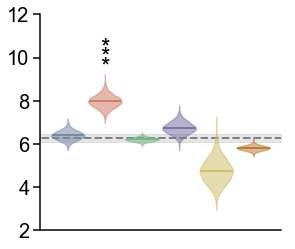

In [202]:
# Set up figure
fig = plt.figure(figsize=(3.35, 3))
ax = fig.add_axes([0,0,1,1])

# Mean as line plot
xs = range(-1, len(rdoc_doms)+1)
data = sorted(list(cit_norm_dom_boot[-1,:]))
plt.plot(xs, [np.mean(data)] * len(xs), "gray", 
         linestyle="dashed", linewidth=2, zorder=-100)
plt.fill_between(xs, 
                 data[int(n_iter*0.001)], y2=data[int(n_iter*0.999)], 
                 color="gray", alpha=0.2, zorder=-100)

# Violin plots
for i, dom in enumerate(rdoc_doms):
    data = sorted(cit_norm_dom_boot[i,:])
    obs = cit_norm_dom[i]
    plt.plot([i-0.41, i+0.42], [obs, obs], 
             c=rdoc_palette[i], alpha=1, lw=2)
    v = ax.violinplot(data, positions=[i], showmeans=False, 
                      showmedians=False, widths=0.9)
    for pc in v["bodies"]:
        pc.set_facecolor(rdoc_palette[i])
        pc.set_edgecolor(rdoc_palette[i])
        pc.set_linewidth(1.25)
        pc.set_alpha(0.55)
    for line in ["cmaxes", "cmins", "cbars"]:
        v[line].set_edgecolor("none")

    # Comparison test
    alphas = [0.05, 0.01, 0.001]
    dys = [0.0, 0.45, 0.9]
    for alpha, dy in zip(alphas, dys):
        if df.loc[dom, "P_COR"] < alpha:
            plt.text(i-0.14, max(data) + dy, 
                     "*", fontproperties=prop_lg)

# Set plot parameters
plt.xticks([])
plt.yticks(range(2,14,2), fontproperties=prop_md)
plt.xlim([-0.75, len(rdoc_doms)-0.25])
# plt.ylim([0, ymax[d]]) 
for side in ["right", "top"]:
    ax.spines[side].set_visible(False)
ax.xaxis.set_tick_params(width=1.5, length=7)
ax.yaxis.set_tick_params(width=1.5, length=7)

# Export figure
plt.savefig("figures/cogneuro/citations_rdoc_{}iter.png".format(n_iter), 
            dpi=250, bbox_inches="tight")
plt.show()

## Segment by both

In [97]:
cit_norm_dom = {part: np.empty(len(rdoc_doms)) for part in parts}
for i, part in enumerate(parts):
    print("-" * 3 + part + "-" * 3 + "\n")
    for j, dom in enumerate(rdoc_doms):
        idx = np.logical_and(pmids_rdoc == i, doc2dom == j)
        dom_mean = np.mean(cit_norm[idx])
        cit_norm_dom[part][j] = dom_mean
        print("{:20s} {:6.4f}".format(dom, dom_mean))
    print("\n")

---RDoC Did NOT Occur---

NEGATIVE_VALENCE     6.4273
POSITIVE_VALENCE     8.0289
COGNITIVE_SYSTEMS    6.2195
SOCIAL_PROCESSES     6.7618
AROUSAL_REGULATION   4.7669
SENSORIMOTOR_SYSTEMS 5.8233


---RDoC Occurred---

NEGATIVE_VALENCE     4.3214
POSITIVE_VALENCE     4.8223
COGNITIVE_SYSTEMS    4.4800
SOCIAL_PROCESSES     4.0333
AROUSAL_REGULATION      nan
SENSORIMOTOR_SYSTEMS 3.0781


